### 1 Load the geometry for the region being analyzed


In [11]:
# The usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Show all columns in dataframes
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");
import osmnx as ox

NYC = gpd.read_file("new-york-city-boroughs.geojson")
NYC_M = NYC[NYC["name"] == "Manhattan"]

NYC_M

,name,cartodb_id,created_at,updated_at,geometry
3,Manhattan,4,2013-03-09 02:42:03.692000+00:00,2013-03-09 02:42:03.989000+00:00,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."


### 2 Get the street network graph


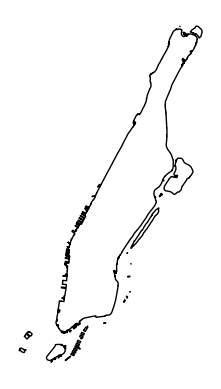

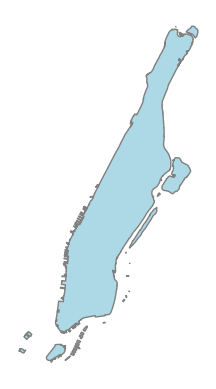

In [27]:
# Project it to Web Mercator first and plot
ax = NYC_M.to_crs(epsg=4326).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()

ax = ox.project_gdf(NYC_M).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

### 3 Convert your network graph edges to a GeoDataFrame

                                                 osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42421731 42437916 0                            5671485   Manhattan Avenue   
         42432737 0                          195743186   Manhattan Avenue   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary      NaN   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.275   
42421731 42437916 0    residential      NaN   False     True   86.149   
         42432737 0   

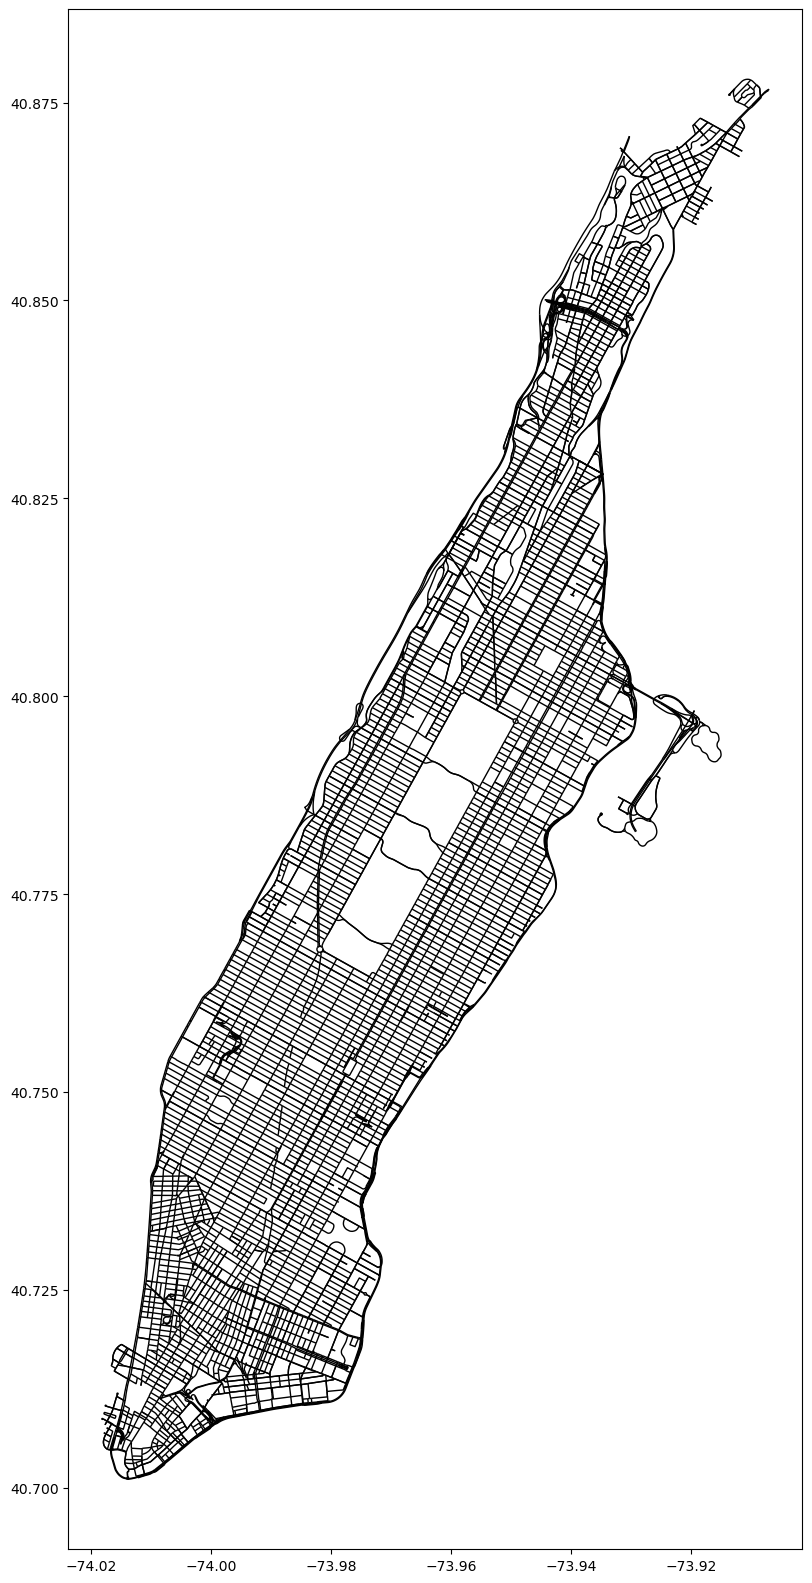

In [28]:
# Define your polygon boundary (replace with your actual polygon)
# For example, if you have a GeoDataFrame with your area boundary:
polygon = NYC_M.unary_union  

# Create a street network graph
G = ox.graph_from_polygon(polygon, network_type='drive')

# Convert graph edges to a GeoDataFrame
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Display the first few rows of the GeoDataFrame
print(edges_gdf.head())

# Plot the edges GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 20))
edges_gdf.plot(ax=ax, linewidth=1, edgecolor='black')
plt.show()

### 4 Load Crash Data

In [5]:
# Load data into a pandas DataFrame
data = pd.read_csv("Motor_Vehicle_Collisions_Crashes.csv")


In [6]:
data

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,05/01/2021,13:30,MANHATTAN,10029.0,40.796300,-73.938290,"(40.7963, -73.93829)",EAST 115 STREET,2 AVENUE,NaN,0,0,0,0,0,0,0,0,Passing or Lane Usage Improper,Unspecified,NaN,NaN,NaN,4412937,Bus,Sedan,NaN,NaN,NaN
1,05/01/2021,17:50,MANHATTAN,10012.0,40.720936,-73.993805,"(40.720936, -73.993805)",BOWERY,SPRING STREET,NaN,1,0,0,0,0,0,1,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4412445,Sedan,Sedan,NaN,NaN,NaN
2,05/01/2021,13:30,MANHATTAN,10128.0,40.780693,-73.946600,"(40.780693, -73.9466)",EAST 92 STREET,1 AVENUE,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4414390,AMBULANCE,Sedan,NaN,NaN,NaN
3,05/01/2021,9:40,MANHATTAN,10026.0,40.800537,-73.948360,"(40.800537, -73.94836)",NaN,NaN,40 WEST 115 STREET,0,0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4417017,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
4,05/01/2021,23:03,MANHATTAN,10009.0,40.726864,-73.979910,"(40.726864, -73.97991)",AVENUE B,EAST 10 STREET,NaN,1,0,0,0,1,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4412243,Bike,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32364,12/31/2023,23:18,MANHATTAN,10030.0,40.819670,-73.944240,"(40.81967, -73.94424)",8 AVENUE,WEST 140 STREET,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,4692572,Sedan,NaN,NaN,NaN,NaN
32365,12/31/2023,18:03,MANHATTAN,10039.0,40.824130,-73.940980,"(40.82413, -73.94098)",8 AVENUE,WEST 147 STREET,NaN,1,0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4692571,NaN,NaN,NaN,NaN,NaN
32366,12/31/2023,14:00,MANHATTAN,10028.0,40.777890,-73.955890,"(40.77789, -73.95589)",NaN,NaN,160 EAST 84 STREET,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4692524,Sedan,Sedan,NaN,NaN,NaN
32367,12/31/2023,21:34,MANHATTAN,10033.0,40.849308,-73.931920,"(40.849308, -73.93192)",WEST 182 STREET,AUDUBON AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4692192,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


### 5 Convert the crash data to a GeoDataFrame

In [31]:
from shapely.geometry import Point

# Check if the necessary columns exist
if 'LATITUDE' in data.columns and 'LONGITUDE' in data.columns:
    # Create a geometry column using the DEC_LAT and DEC_LONG columns
    geometry = [Point(xy) for xy in zip(data['LATITUDE'], data['LONGITUDE'])]
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)

    # Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
    gdf.set_crs(epsg=2263, inplace=True)

    # Display the first few rows of the GeoDataFrame
    print(gdf.head())
else:
    print("The DataFrame does not contain 'DEC_LAT' and 'DEC_LONG' columns.")

   CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  05/01/2021      13:30  MANHATTAN   10029.0  40.796300 -73.938290   
1  05/01/2021      17:50  MANHATTAN   10012.0  40.720936 -73.993805   
2  05/01/2021      13:30  MANHATTAN   10128.0  40.780693 -73.946600   
3  05/01/2021       9:40  MANHATTAN   10026.0  40.800537 -73.948360   
4  05/01/2021      23:03  MANHATTAN   10009.0  40.726864 -73.979910   

                  LOCATION   ON STREET NAME CROSS STREET NAME  \
0     (40.7963, -73.93829)  EAST 115 STREET          2 AVENUE   
1  (40.720936, -73.993805)           BOWERY     SPRING STREET   
2    (40.780693, -73.9466)   EAST 92 STREET          1 AVENUE   
3   (40.800537, -73.94836)              NaN               NaN   
4   (40.726864, -73.97991)         AVENUE B    EAST 10 STREET   

             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                        NaN                          0   
1                        NaN                          1   
2    

### 6 Trim the crash data to Center City

In [32]:
# Assuming edges_gdf is your GeoDataFrame from part 1.3
manhattan_boundary = edges_gdf.geometry.unary_union.convex_hull

# Filter the crash GeoDataFrame to only include crashes within the boundary
manhattan_crashes = gdf[gdf.geometry.within(manhattan_boundary)]

# Display the number of crashes within the Center City boundary
print(f"Number of crashes within manhattan: {len(manhattan_crashes)}")

# Display the first few rows of the filtered GeoDataFrame
manhattan_crashes.head()

Number of crashes within manhattan: 0


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry


### 7 Re-project our data into an approriate CRS2263

C:\Users\willi\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


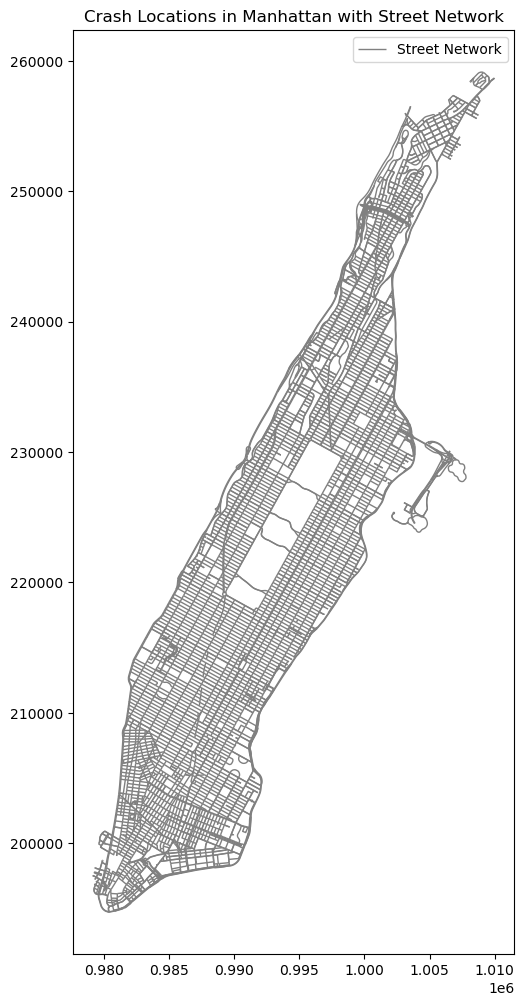

In [30]:
import osmnx as ox

# Assuming G is your graph object
# Project the graph to the Philadelphia state plane CRS (EPSG:2272)
G_projected = ox.project_graph(G, to_crs='EPSG:2263')

# Project the crash GeoDataFrame to the Philadelphia state plane CRS (EPSG:2272)
manhattan_crashes_projected = manhattan_crashes.to_crs(epsg=2263)

# Display the first few rows of the projected GeoDataFrame
manhattan_crashes_projected.head()

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the street network
edges_gdf_projected = ox.graph_to_gdfs(G_projected, nodes=False)
edges_gdf_projected.plot(ax=ax, linewidth=1, edgecolor='gray', label='Street Network')

# Plot the crash locations
manhattan_crashes_projected.plot(ax=ax, marker='o', color='red', markersize=5, label='Crashes')

# Add a title and legend
plt.title('Crash Locations in Manhattan with Street Network')
plt.legend()

# Show the plot
plt.show()